In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np 
import os
from itertools import chain
from scipy.fft import fft, fftfreq
from fooof import FOOOF
import seaborn as sns
import pandas as pd

C:\Users\leofl\AppData\Local\Temp\ipykernel_62928\4032007646.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [ ]:
def process_eeg_files(folder_path):
    """
    What this fuction does is ultimately creates the dictionary with all the nescessay features for the analysis. y frequencies dict
    contains for each participant divided by the trial type (frequent_rare, rare_frequent, frequent_frequent) and gives 
    ['yf_avg_pre', 'yf_avg_post', 'post_minus_erp', 'fft_erp', 'xf', 'xf_erp']. Then yf data also contains aperiodic params and r squared.
    """
    y_frequencies_dict = {}
    
    # Loop over all .set files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.set'):
            file_path = os.path.join(folder_path, filename)
            raw_eeg = mne.io.read_raw_eeglab(file_path, preload=True)
            
            # Preprocess the raw EEG data
            raw_eeg = preprocess_raw_eeg(raw_eeg)
            
            # Extract and modify events for epochs
            events, event_id = extract_and_modify_events(raw_eeg)
            
            # Create epochs
            epochs = create_epochs(raw_eeg, events, event_id)

            conditions = ['frequent_rare', 'rare_frequent', 'frequent_frequent']
            
            y_frequencies_dict[filename.split('.')[0]] = {}
            for condition in conditions: 

                # Separate epochs into pre and post-stimulus windows
                epochs_pre, epochs_post = separate_epochs(epochs[condition])

                assert len(epochs_pre) == len(epochs_post)
                
                # Perform FFT on the Pz channel data
                yf_avg_pre, yf_avg_post = perform_fft_on_epochs(epochs_pre, epochs_post)
                
                xf = get_xf(epochs_pre)

                assert yf_avg_pre.shape == xf.shape 

                #Compute ERP for condition
                erp = compute_erp(epochs_post[condition])

                #Compute FFT for ERP
                fft_erp = perform_fft_on_erp(erp)
                
                xf_erp = get_xf(erp)
                
                assert fft_erp.shape == xf_erp.shape

                #subtracting the erp  from the post event data for each candidate
                post_minus_erp = yf_avg_post - fft_erp

                power_spec_windows = [
                    ("yf_avg_pre", yf_avg_pre),
                    ("yf_avg_post", yf_avg_post),
                    ("post_minus_erp", post_minus_erp)
                ]
                results = {}
                for name, power_spec in power_spec_windows:
                
                    fg = FOOOF(
                        #had to modify peak width limits because using different time series data then gyurkovics
                            peak_width_limits=[2.5, 8],
                            max_n_peaks= 1,
                            min_peak_height=0.3,
                            peak_threshold=2.0,
                            aperiodic_mode='fixed'
                        )

                    #the parameters for fit are frequency data of the power spectra (xf) and frequency (yf_avg) 
                    #frequency range from gyurkovics defined a as >2 hz but <25hz
                    #now we need to filter out the 8-12hz alpha range as this will cause positive foof values
                    fg.fit(xf, power_spec, freq_range= (2,25))

                    aps = fg.get_params('aperiodic_params')
                    rsq = fg.get_params('r_squared')

                    results[name] = {
                            name : power_spec,
                            'aps': aps,
                            'rsq': rsq,
                        }
                
                results.update({
                        'fft_erp': fft_erp,
                        'xf': xf,
                        'xf_erp' : xf_erp 
                })

                # results = results + [fft_erp, xf, xf_erp]
                # Update the dictionary with the results
                y_frequencies_dict[filename.split('.')[0]][condition] = results
    
    return y_frequencies_dict\

def preprocess_raw_eeg(raw_eeg):
    """
    Preprocess the raw EEG data by setting the montage, renaming channels, and setting channel types.
    """
    # Set standard 10-20 montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_eeg.rename_channels({"FP1": 'Fp1', 'FP2': 'Fp2'})
    raw_eeg.set_channel_types({
        'HEOG_left': 'eog', 'HEOG_right': 'eog',
        'VEOG_lower': 'eog', '(uncorr) HEOG': 'eog',
        '(uncorr) VEOG': 'eog'
    })
    raw_eeg.set_montage(montage)
    return raw_eeg

def extract_and_modify_events(raw_eeg):
    """
    Extract events from annotations and modify event IDs according to specific conditions.
    """
    events, _ = mne.events_from_annotations(raw_eeg)
    
    # Remove events with IDs 6 and 7
    events = events[~np.isin(events[:, 2], [6, 7])]
    
    # Define target and non-target event IDs
    target_ids = [1, 9, 15, 21, 27]
    nontarget_ids = [2, 3, 4, 5, 8, 10, 11, 12, 13, 14,
                     16, 17, 18, 19, 20, 22, 23, 24, 25, 26]
    
    # Modify event IDs based on conditions
    for i in range(len(events)):
        current_id = events[i, 2]
        if current_id in target_ids:
            events[i, 2] = 100  # 'frequent_rare'
        elif (i > 0 and current_id in nontarget_ids and
              events[i - 1, 2] == 100):
            events[i, 2] = 200  # 'rare_frequent'
        elif (i > 0 and current_id in nontarget_ids and
              events[i - 1, 2] in [200, 300]):
            events[i, 2] = 300  # 'frequent_frequent'
    
    # Define new event IDs
    event_id = {
        "frequent_rare": 100,
        "rare_frequent": 200,
        "frequent_frequent": 300
    }
    return events, event_id

def create_epochs(raw_eeg, events, event_id):
    """
    Create epochs from the raw EEG data using the modified events.
    """
    epochs = mne.Epochs(
        raw_eeg, events=events, event_id=event_id,
        tmin=-0.6, tmax=0.6, picks=['Pz'],
        baseline=None, preload=True
    )
    return epochs

def separate_epochs(epochs):
    """
    Separate epochs into pre-stimulus and post-stimulus windows.
    """
    epochs_pre = epochs.copy().crop(tmin=-0.6, tmax=0)
    epochs_post = epochs.copy().crop(tmin=0, tmax=0.6)
    return epochs_pre, epochs_post

def perform_fft_on_epochs(epochs_pre, epochs_post):
    """
    Perform FFT on the Pz channel data of pre and post-stimulus epochs.
    """
    # .get_data() Shape: (n_epochs x n_channels x n_samples)
    pre_data = epochs_pre.copy().pick(['Pz']).get_data()  # Select PZ Shape: n_epochs x 1 x n_samples
    post_data = epochs_post.copy().pick(['Pz']).get_data()

    # Remove channel dimension 
    pre_data = pre_data[:, 0, :]  # now n_epochs x n_samples
    post_data = post_data[:, 0, :]

    # Compute FFT for each trial
    pre_spectra = np.abs(fft(pre_data, axis=1))  # axis 1 applies FFT along n_samples
    post_spectra = np.abs(fft(post_data, axis=1)) # resulting arraray now for each epoch

    # Avg after FFT in freq domain
    yf_avg_pre = pre_spectra.mean(axis=0)  # now averaging across trials (epochs)
    yf_avg_post = post_spectra.mean(axis=0) # so will give 1 row of sample data
    
    return yf_avg_pre, yf_avg_post

def compute_erp(epochs_post): 
    erp = epochs_post.average() 
    return erp

def perform_fft_on_erp(erp):
    data = erp.pick(['Pz']).get_data()
    print(data.shape)
    erp_mean = data.mean(axis=0)
    print(erp_mean.shape)
    erp_avg =  np.abs(fft(erp_mean))
    return erp_avg


def get_xf(epoch_window):

    # Getting the sampling frequency
    sample_rate = epoch_window.info['sfreq']

    # Acessing the num of epochs, channels, and time points
    data = epoch_window.get_data()

    #N is required for xf calculations
    N = data.shape[-1]

    xf = fftfreq(N, 1/sample_rate)
    return xf

if __name__ == '__main__':
    folder_path = "C:/Users/leofl/OneDrive/Desktop/ERP Data/Project Cygnus/"
    y_frequencies_dict = process_eeg_files(folder_path)
    # Now y_frequencies_dict contains the FFT results for each file

In [3]:
print(len(y_frequencies_dict['p3_1']['frequent_frequent']['fft_erp']))
print(len(y_frequencies_dict['p3_1']['frequent_frequent']['fft_erp']))
print(len(y_frequencies_dict['p3_1']['frequent_frequent']['fft_erp']))
print(len(y_frequencies_dict['p3_1']['frequent_frequent']['fft_erp']))
print(len(y_frequencies_dict['p3_1']['frequent_frequent']['fft_erp']))

155
155
155
155
155


In [4]:
print(y_frequencies_dict['p3_4']['frequent_frequent'].keys())

dict_keys(['yf_avg_pre', 'yf_avg_post', 'post_minus_erp', 'fft_erp', 'xf', 'xf_erp'])


In [ ]:
for participant in y_frequencies_dict:
    for condition in y_frequencies_dict[participant]:

        # Access yf_avg_pre (Index 0)
        yf_avg_pre = y_frequencies_dict[participant][condition]['yf_avg_pre']['yf_avg_pre']

        # Access yf_avg_post (Index 1)
        yf_avg_post = y_frequencies_dict[participant][condition]['yf_avg_post']['yf_avg_post']

        # Acess the frequencies (Index 3)
        xf = y_frequencies_dict[participant][condition]['xf']

        # Acess number of samples
        N = len(xf)

        # Filtering frequencies above 25 hz
        mask = (xf[:N // 2] <= 25) & (xf[:N // 2] > 2)

        # convert yf_avg_pre and post from volts to microvolts
        scaling_factor = 1e6  # From volts to microvolts
        yf_avg_pre_scaled = yf_avg_pre * scaling_factor**2  # Convert amplitude^2
        yf_avg_post_scaled = yf_avg_post * scaling_factor**2

        plt.plot(xf[:N // 2][mask], yf_avg_pre_scaled[:N // 2][mask], color = 'blue', label = 'pre-event')
        plt.plot(xf[:N // 2][mask], yf_avg_post_scaled[:N // 2][mask],  color = 'red', label = 'post-event')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(r'Power ($\mu V^2/Hz$)')
        plt.title(f'{participant}'+ ' ' + f'{condition} Power Spectrum')
        plt.legend()
        plt.grid(True)
        plt.show()

(20, 155) (20, 155)


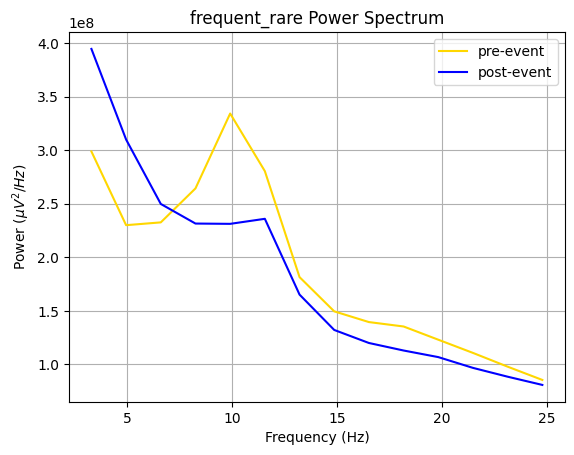

(20, 155) (20, 155)


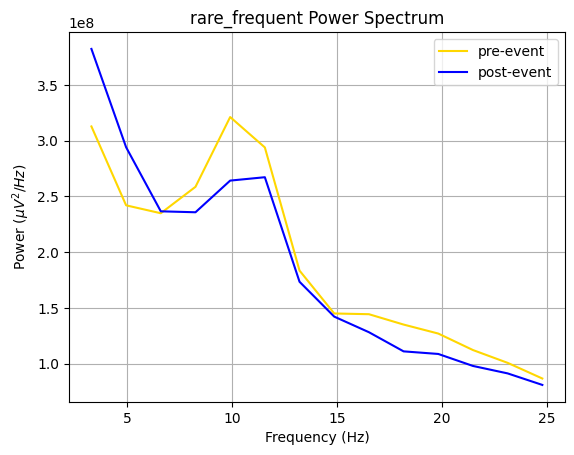

(20, 155) (20, 155)


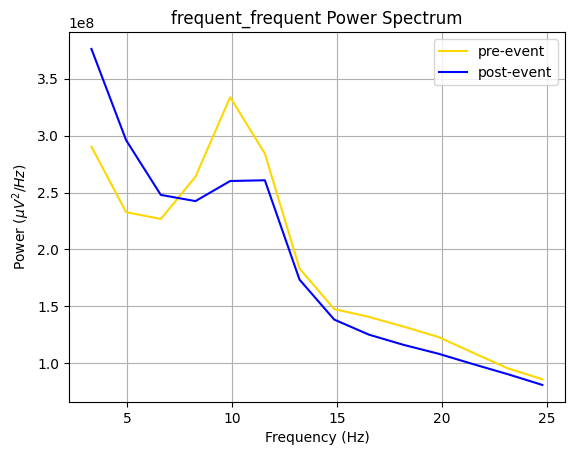

In [6]:
conditions = ['frequent_rare', 'rare_frequent', 'frequent_frequent']


for condition in conditions:  
    yf_avg_pre_list = np.zeros(155)
    yf_avg_post_list =  np.zeros(155)
    for participant in y_frequencies_dict:
        # Access yf_avg_pre (Index 0)
        yf_avg_pre = y_frequencies_dict[participant][condition]['yf_avg_pre']['yf_avg_pre']
        # Access yf_avg_post (Index 1)
        yf_avg_post = y_frequencies_dict[participant][condition]['yf_avg_post']['yf_avg_post']

        #vertically stacks 
        yf_avg_pre_list = np.vstack((yf_avg_pre_list, yf_avg_pre))
        yf_avg_post_list = np.vstack((yf_avg_post_list, yf_avg_post))

    yf_avg_pre_list = yf_avg_pre_list[1:,:]
    yf_avg_post_list = yf_avg_post_list[1:,:]
        
    print(yf_avg_pre_list.shape, yf_avg_post_list.shape)
    # Acess the frequencies (Index 3) (doesnt matter which one we use so just used first index)
    xf = y_frequencies_dict['p3_1']['frequent_rare']['xf']

    # Acess number of samples
    N = len(xf)

    # Filtering frequencies above 25 hz
    mask =  (xf[:N // 2] > 2) & (xf[:N // 2] <= 25)

    # Take the average across particpants (axis 0 since participants in rows)
    yf_avg_pre_mean =  np.mean(yf_avg_pre_list, axis = 0)
    yf_avg_post_mean =  np.mean(yf_avg_post_list, axis = 0)


    # convert yf_avg_pre and post from volts to microvolts
    scaling_factor = 1e6  # From volts to microvolts
    yf_avg_pre_scaled = yf_avg_pre_mean * scaling_factor**2  # Convert amplitude^2
    yf_avg_post_scaled = yf_avg_post_mean * scaling_factor**2

    plt.plot(xf[:N // 2][mask], yf_avg_pre_scaled[:N // 2][mask], color = 'gold', label = 'pre-event')
    plt.plot(xf[:N // 2][mask], yf_avg_post_scaled[:N // 2][mask],  color = 'blue', label = 'post-event')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Power ($\mu V^2/Hz$)')
    plt.title(f'{condition} Power Spectrum')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# to make the violin plots I think that 
# how do they vary the exponenets on the x axis?
# I think I need to get the aperiodic compoent from each person in a list

y_frequencies_dict['p3_1']['frequent_rare']['yf_avg_post']['yf_avg_post'].shape

(155,)

In [8]:
# aps_dict = {
#     "frequent_rare": {
#                 "pre": [],
#                 "post": [],
#                 "post-erp": []
#                 },
#     "rare_frequent": {
#                 "pre": [],
#                 "post": [],
#                 "post-erp": []
#                 },
#     "frequent_frequent": {
#                 "pre": [],
#                 "post": [],
#                 "post-erp": []
#                 },
# }

# # what if I have this a overall dictionary called aps dict -- then I have 3 keys based on pip type, then each of those have 3 keys (pre, post, and post-erp) which are lists
# for participant in y_frequencies_dict:
#     for condition in y_frequencies_dict[participant]:
#         if condition == 'frequent_rare':
#             aps_dict["frequent_rare"]["pre"].append(y_frequencies_dict[participant][condition]['yf_avg_pre']['aps'][1])
#             aps_dict["frequent_rare"]["post"].append(y_frequencies_dict[participant][condition]['yf_avg_post']['aps'][1])
#             aps_dict["frequent_rare"]["post-erp"].append(y_frequencies_dict[participant][condition]['post_minus_erp']['aps'][1])
#         elif condition == 'rare_frequent':
#             aps_dict["rare_frequent"]["pre"].append(y_frequencies_dict[participant][condition]['yf_avg_pre']['aps'][1])
#             aps_dict["rare_frequent"]["post"].append(y_frequencies_dict[participant][condition]['yf_avg_post']['aps'][1])
#             aps_dict["rare_frequent"]["post-erp"].append(y_frequencies_dict[participant][condition]['post_minus_erp']['aps'][1])
#         else:
#             aps_dict["frequent_frequent"]["pre"].append(y_frequencies_dict[participant][condition]['yf_avg_pre']['aps'][1])
#             aps_dict["frequent_frequent"]["post"].append(y_frequencies_dict[participant][condition]['yf_avg_post']['aps'][1])
#             aps_dict["frequent_frequent"]["post-erp"].append(y_frequencies_dict[participant][condition]['post_minus_erp']['aps'][1])


In [9]:
y_frequencies_dict['p3_1']['frequent_rare']['yf_avg_pre'].keys()

dict_keys(['yf_avg_pre', 'aps', 'rsq'])

In [14]:
def create_df(y_frequencies_dict):
    """
    This function uses the y_frequencies dict to create a more acessible data frame with the
    participant, time window, condition, exponent, offset, and rsq values.
    """
    time = ['yf_avg_pre', 'yf_avg_post', 'post_minus_erp']
    participants_col = []
    condition_col = []
    time_win_col = []
    exp_col = []
    offset_col = []
    rsq_col = []


    for participant in y_frequencies_dict:
        for condition in y_frequencies_dict[participant]:
            for time_window in time:
                    exp = y_frequencies_dict[participant][condition][time_window]['aps'][1]
                    offset = y_frequencies_dict[participant][condition][time_window]['aps'][0]
                    rsq = y_frequencies_dict[participant][condition][time_window]['rsq']

                    participants_col.append(participant)
                    condition_col.append(condition)
                    time_win_col.append(time_window)
                    exp_col.append(exp)
                    offset_col.append(offset)
                    rsq_col.append(rsq)

    a = pd.DataFrame()
    a['Participant'] = participants_col
    a['Condition'] = condition_col
    a['Time Window'] =  time_win_col
    a['Exp'] =   exp_col
    a['Offset'] = offset_col
    a['Rsq'] = rsq_col

    # assert that each participant has exactly 9 rows
    participant_counts = a.groupby('Participant').size()
    assert (participant_counts == 9).all(), f"Some participants do not have exactly 9 rows:\n{participant_counts[participant_counts != 9]}"

    #assert that each time condition has all three time windows
    time_window_counts = a.groupby(['Participant','Time Window']).size()
    assert(time_window_counts == 3).all(), f"Some participants do not have exactly 9 rows:\n{time_window_counts[time_window_counts != 9]}"

    return a 



In [ ]:
def r_squared_hist(a):
    #R squared histogram plot 
    return sns.histplot(
        data = a,
        x = "Rsq"
    )

In [33]:
a = create_df(y_frequencies_dict)

In [35]:
a[a['Condition'] == 'frequent_frequent']

,Participant,Condition,Time Window,Exp,Offset,Rsq
6,p3_1,frequent_frequent,yf_avg_pre,0.344783,-3.386503,0.952567
7,p3_1,frequent_frequent,yf_avg_post,0.467285,-3.287173,0.979250
8,p3_1,frequent_frequent,post_minus_erp,0.220571,-3.671691,0.953643
15,p3_10,frequent_frequent,yf_avg_pre,0.652256,-3.186270,0.983537
16,p3_10,frequent_frequent,yf_avg_post,0.786420,-3.031025,0.977722
17,p3_10,frequent_frequent,post_minus_erp,0.654647,-3.313909,0.909641
24,p3_11,frequent_frequent,yf_avg_pre,0.756047,-3.144650,0.861484
25,p3_11,frequent_frequent,yf_avg_post,1.029775,-2.845840,0.969860
26,p3_11,frequent_frequent,post_minus_erp,0.852617,-3.324019,0.798144
33,p3_12,frequent_frequent,yf_avg_pre,0.616809,-3.233974,0.929937


In [38]:
def violin_plots(a):
    """
    Function takes the dataframe a and slices it based on pip condition.
    With the sliced conditions, it uses takes the exponent values at 
    different time values to make seperate violin plots. This is done 
    through a for loop of the different sliced data frames.
    """
    frequent_rare_df = a[a['Condition'] == 'frequent_rare']
    rare_frequent_df = a[a['Condition'] == 'rare_frequent']
    frequent_frequent_df = a[a['Condition'] == 'frequent_frequent']

    data = [frequent_rare_df, rare_frequent_df, frequent_frequent_df] #list of sliced dfs
    titles = ["Frequent_Rare", "Rare_Frequent", 'Frequent_Frequent'] #list of titles
    for index, df in enumerate(data): #enumarete gives index and objects from lists
        
        sns.violinplot(data= df,
                x='Time Window',
                y='Exp',
                palette = 'pastel',
                inner = 'box',
                linewidth= 1.1)

        sns.stripplot( #overlaying actual values onto violin plot 
            data= df,
            x='Time Window',
            y='Exp',
            color='grey',  # grey points
            alpha=0.7,  # Adjust transparency
            jitter= 0.08  # Add jitter
        )

        plt.xlabel("Epoch Time Window")
        plt.ylabel("Exponent Value")
        plt.title(titles[index]) #using the df index to get the corresponding title

        plt.ylim((-0.2, 1.3)) # standardizing y limits for all the violin plots 
        plt.show()

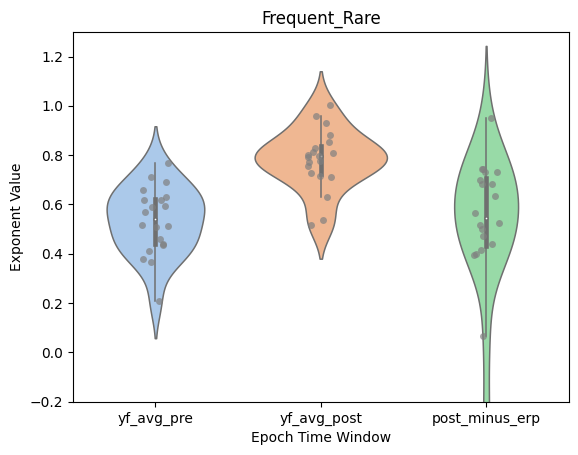

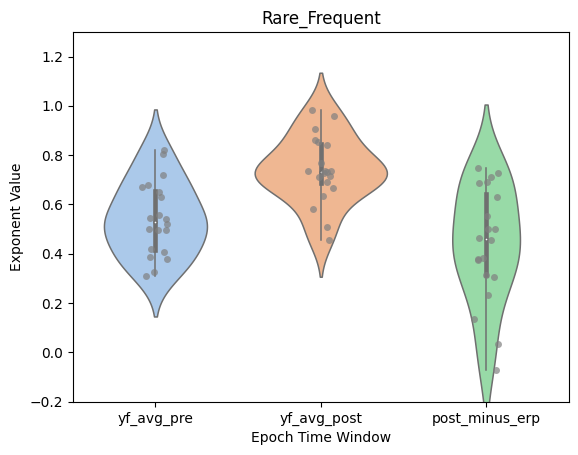

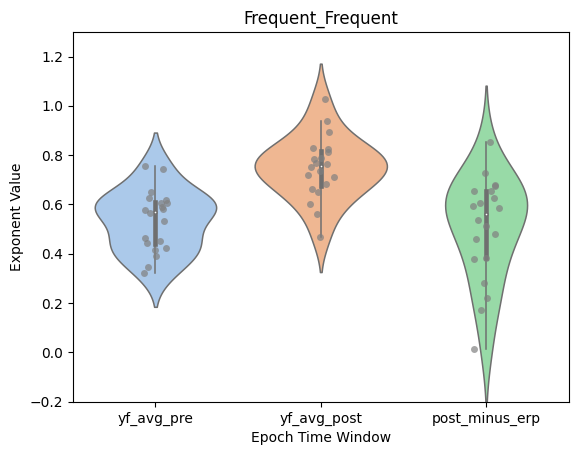

In [39]:
violin_plots(a)

In [ ]:
length = ???
pre_array = np.zeroes(20,length )
post_array = np.zeroes(20, length)
for i in folder_path: 
    half_way = np.len(i) / 2
    pre = i[:half_way]
    post = i[half_way:]

    pre_array = pre_array.vstack(pre)
    post_array = post_array.vstack(post)
